In [3]:
# need to do this before transformer imports
import os
os.environ['HF_HOME'] = '/workspace/cache/huggingface/'

import os
os.chdir('/workspace/FutureGPT2/src/')
from evals.utils import *
from models.bigram_model import *
from models.mlp_model import *
from models.future_model import *
from data.utils import get_tokenizer
import datasets
from torch.utils.data import DataLoader
from torch import nn
from itertools import islice
from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

from tqdm import tqdm
import pandas as pd
import gc
from glob import glob
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore")

In [4]:
MODEL = 'MISTRAL'
dataset = datasets.load_from_disk(f'/workspace/corpus/msmarco/msmarco_{MODEL}_64tokens_1m').with_format('torch', device=torch.device('cuda'))
test = dataset['test']

In [5]:
loader = DataLoader(test, batch_size=128)

In [4]:
glob('/workspace/checkpoints/MISTRAL-NECK-SWEEP_*_hidden_idxs-*_hidden_lb--1_token_lb-0_neck_cls-mlp*')[0]

'/workspace/checkpoints/MISTRAL-NECK-SWEEP_20240102-003452-6d828_hidden_idxs-0_hidden_lb--1_token_lb-0_neck_cls-mlp_epoch=00-val_self_loss=6.85.ckpt'

In [6]:
ckpt_path_d = {
    't': glob('/workspace/checkpoints/MISTRAL-NECK-SWEEP_*_hidden_idxs-*_hidden_lb--1_token_lb-0_neck_cls-mlp*')[0],
    'ht': glob('/workspace/checkpoints/MISTRAL-NECK-SWEEP_*_hidden_idxs-32_hidden_lb-0_token_lb-0_neck_cls-mlp*')[0]
}

In [7]:
torch.set_grad_enabled(False)

In [8]:
model_d = dict()
for name in ckpt_path_d:
    model_d[name] = LitFutureModelWithNeck.load_from_checkpoint(ckpt_path_d[name], strict=False).to('cuda')
    gc.collect()
    torch.cuda.empty_cache()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [9]:
for name in model_d:
    model_d[name].loss_func = nn.CrossEntropyLoss(reduction='none')

In [11]:
losses = {k: [] for k in model_d}
ids = []
test_iter = iter(loader)
for batch in tqdm(islice(test_iter, 2)):
    for name, model in model_d.items():
        loss = model._compute_loss(batch)
        losses[name].append(loss.self_loss.reshape(-1, 63).cpu().detach())  # (seq_length-1)=63
    ids += batch['id']
    gc.collect()
    torch.cuda.empty_cache()
for k in losses:
    losses[k] = torch.concatenate(losses[k], axis=0)

0it [00:00, ?it/s]

TODO!!!!! uncomment total_loss term!!!!
TODO!!!!! uncomment total_loss term!!!!


1it [00:13, 13.73s/it]

TODO!!!!! uncomment total_loss term!!!!
TODO!!!!! uncomment total_loss term!!!!


2it [00:27, 13.77s/it]


In [12]:
loss_diffs = losses['t'] - losses['ht']

In [14]:
topk_val, topk_ind = loss_diffs.flatten().topk(10)
#topk_val, topk_ind = (-losses).flatten().topk(10)
topk_ind = np.array(np.unravel_index(topk_ind.numpy(), loss_diffs.shape)).T

In [15]:
len(data)

TypeError: object of type 'module' has no len()

In [16]:
def get_row(data, id):
    idx = data['id'].index(id)
    return {k: data[k][idx] for k in ['text', 'input_ids', 'attention_mask']}

In [230]:
model_name = 'mistralai/Mistral-7B-v0.1'

tokenizer = AutoTokenizer.from_pretrained(model_name)
Token = {v: k for k, v in tokenizer.get_vocab().items()}

def topk(v, k=40, aux=None):
    # Takes in logits
    #v = softmax(v.flatten())
    v = v.flatten()
    idxs = v.argsort()[-k:][::-1]
    if aux:
        ret = [(Token[i], v[i]) + tuple(aux[i]) for i in idxs]
        return pd.DataFrame(ret, columns=['token', 'logit'] + list(range(len(aux[0]))))
    else:
        ret = [(Token[i], v[i]) for i in idxs]
        return pd.DataFrame(ret, columns=['token', 'logit'])

In [26]:
for ind, val in zip(topk_ind, topk_val):
    row = get_row(test, ids[ind[0]])
    input_ids = row['input_ids'][:ind[1] + 2] # loss at seq idx n corresponds to forward pass at idx n+1
    input_ids = input_ids.unsqueeze(0) # add batch dim
    out = model_d['ht']({'input_ids': input_ids.to('cuda'), 'attention_mask': torch.ones(input_ids.shape).to('cuda')})
    base_prev = out.logits[0, ind[1],:]
    base = out.logits[0, ind[1] + 1,:]
    future = out.future_logits[0, ind[1],:]
    out_t = model_d['t']({'input_ids': input_ids.to('cuda'), 'attention_mask': torch.ones(input_ids.shape).to('cuda')})
    future_t = out_t.future_logits[0, ind[1],:]
    out_str = '|'.join(Token[i] for i in input_ids.cpu().flatten().numpy())
    if ind[1] + 2 < 64:
        out_str += '(' + Token[row['input_ids'][ind[1] + 2].item()] + ')'
    print(out_str)
    print('BASE vs FUTURES:')
    print(pd.concat([
        #topk(base_prev.cpu().numpy(), k=10).rename(columns={'token': 'base-1'}),
        topk(base.cpu().numpy(), k=10).rename(columns={'token': 'base'}),
        topk(future.cpu().detach().numpy(), k=10).rename(columns={'token': 'ht'}),
        topk(future_t.cpu().detach().numpy(), k=10).rename(columns={'token': 't'})
    ], axis=1))
    print('LOSS_HT:', nn.CrossEntropyLoss()(future, torch.softmax(base, dim=0)).item())
    print('LOSS_T:', nn.CrossEntropyLoss()(future_t, torch.softmax(base, dim=0)).item())


<s>|▁A|▁T|AM|▁plane|▁before|▁landing|▁at|▁Sant|os|▁Dum|ont|▁Airport|▁in|▁Rio|▁de|▁Jane|iro|.|▁L|AT|AM|▁Airlines|▁Brasil|,|▁formerly|▁T|AM|▁Airlines|▁(|Port|ug(uese)
BASE vs FUTURES:
   base      logit           ht      logit       t     logit
0  uese  24.244495         uese  15.929122       ,  5.838762
1   ese  16.892418           al   9.846756       .  5.667567
2    al  15.194197           ug   9.845806    ▁and  4.972284
3   ues  13.136635          ian   9.347416       ▁  4.647301
4    ue  12.453605  ▁Portuguese   9.073431       -  4.646937
5     :  12.266930          age   8.388430     ▁of  4.460546
6     .  11.328085          ate   8.297344  <0x0A>  4.394995
7   ies  11.047367           te   8.078945     ▁in  4.393285
8    es  10.708273            ,   7.970072      ▁(  4.271605
9   ess  10.263073     ▁Spanish   7.876432     ▁to  4.180522
LOSS_HT: 0.023796604946255684
LOSS_T: 13.652191162109375
<s>|▁In|▁the|▁summer|time|,|▁cold|▁b|ors|cht|▁is|▁a|▁popular|▁alternative|▁to|▁the|▁a|fore

In [44]:
def print_tokens(s):
    tokens = tokenizer(s)['input_ids']
    print('|'.join(Token[t] for t in tokens))

In [134]:
print_tokens('He is suffering from Alz')

<s>|▁He|▁is|▁suffering|▁from|▁Al|z


In [114]:
prompt = "He is suffering from Alz"
input = tokenizer(prompt, return_tensors='pt').to('cuda')

In [115]:
out_ht = model_d['ht'](input)
out_t = model_d['t'](input)

In [116]:
topk(out_ht.logits.cpu().numpy()[0,-1,:], k=10)

,token,logit
0,heimer,18.213142
1,heim,14.982849
2,he,11.628552
3,hem,11.411487
4,iem,9.082198
5,her,8.648829
6,imer,8.392187
7,ham,7.791391
8,ah,7.698751
9,him,7.618369


In [117]:
topk(out_ht.future_logits.cpu().numpy()[0,-2,:], k=10)

,token,logit
0,heimer,15.253980
1,heim,10.111232
2,",",8.829756
3,▁and,8.012557
4,.,7.978244
5,ar,7.766553
6,ine,7.724874
7,are,7.595370
8,▁D,7.429148
9,ur,7.425232


In [118]:
topk(out_t.future_logits.cpu().numpy()[0,-2,:], k=10)

,token,logit
0,",",5.164260
1,.,5.115747
2,▁and,4.334296
3,▁,4.186111
4,-,4.107753
5,<0x0A>,4.025540
6,▁of,3.809211
7,▁in,3.776166
8,▁(,3.767645
9,▁to,3.569150


In [123]:
A = model_d['ht'].future_neck.layers[0].weight.data.detach().cpu().numpy()

In [125]:
base_model = model_d['ht'].base_model

In [127]:
out = base_model(**input, output_hidden_states=True)

In [138]:
h = out.hidden_states[32][0,-2,:].reshape((-1, 1)).cpu().numpy()

In [139]:
t = out.hidden_states[0][0,-1,:].reshape((-1, 1)).cpu().numpy()

In [156]:
E = base_model.model.embed_tokens.weight.data.cpu().numpy()

In [147]:
D = base_model.lm_head.weight.data.cpu().numpy()

In [158]:
Dpinv = np.linalg.pinv(D)

In [148]:
pred = D @ (A @ np.concatenate([h, t]))

In [160]:
tokenizer('Alzheimer')

{'input_ids': [1, 976, 28764, 24556], 'attention_mask': [1, 1, 1, 1]}

In [165]:
heimer = D[[24556],:] @ A

In [189]:
heimer @ np.concatenate([h, t])

array([[15.601598]], dtype=float32)

In [173]:
t_score = heimer[:,4096:] @ E.T

In [194]:
h_score = heimer[:,:4096] @ D.T

In [195]:
topk(h_score.flatten(), k=10)

,token,logit
0,heimer,0.104696
1,heim,0.034372
2,▁/******/,0.034076
3,BPACK,0.024642
4,pgfscope,0.023644
5,丶,0.023437
6,qpoint,0.022994
7,dhd,0.022988
8,:%.*,0.022927
9,ҽ,0.022492


In [187]:
h_score[0,24556]

0.18687496

In [190]:
heimer[:,:4096] @ h

array([[15.427982]], dtype=float32)

In [180]:
topk(h_score, k=20)

,token,logit
0,heimer,0.186875
1,heim,0.032063
2,iffs,0.019978
3,▁que,0.019484
4,▁S,0.019187
5,<0x0A>,0.018621
6,▁vector,0.017973
7,ً,0.017171
8,ativity,0.017056
9,ister,0.016837


In [177]:
topk(pred)

,token,logit
0,heimer,15.601603
1,heim,10.373470
2,",",8.233823
3,ine,7.715692
4,ar,7.697968
5,are,7.584651
6,▁and,7.517624
7,.,7.445228
8,ur,7.419033
9,hen,7.400190


In [192]:
topk(Dpinv.T @ h, k=10)

,token,logit
0,z,31.079538
1,ugno,24.306639
2,gorith,23.458277
3,cohol,22.437153
4,typen,22.169466
5,nitt,20.925621
6,zh,20.354841
7,umin,18.984793
8,▁laug,18.823332
9,kap,18.677513


In [200]:
topk(D @ h, k=10)

,token,logit
0,z,17.002439
1,cohol,12.438921
2,ze,11.413498
3,zh,11.141702
4,port,11.036744
5,ve,10.207431
6,ien,9.540986
7,kap,9.415344
8,-,9.073519
9,bin,8.962482


In [231]:
topk(heimer[:,:4096] @ Dpinv, k=10)

,token,logit
0,heimer,0.186875
1,heim,0.032063
2,iffs,0.019978
3,▁que,0.019484
4,▁S,0.019187
5,<0x0A>,0.018621
6,▁vector,0.017973
7,ً,0.017171
8,ativity,0.017056
9,ister,0.016837


In [207]:
h_score = (heimer[:,:4096] @ Dpinv).flatten() * (D @ h).flatten()

In [214]:
aux = np.concatenate([(heimer[:,:4096] @ Dpinv).T, D @ h], axis=1)

In [221]:
.186875*7.7158

1.441890125

In [227]:
topk(h_score, aux=aux, k=20)

,token,logit,0,1
0,heimer,1.441899,0.186875,7.715849
1,heim,0.246545,0.032063,7.689373
2,z,0.186114,0.010946,17.002439
3,ag,0.109592,0.014028,7.812175
4,k,0.098598,0.012084,8.159696
5,雅,0.096432,-0.013314,-7.243120
6,<0x0A>,0.095901,0.018621,5.150013
7,▁Marcel,0.094632,-0.019627,-4.821455
8,лек,0.090533,-0.010441,-8.671231
9,ган,0.089963,-0.012672,-7.099144


In [218]:
tuple(aux[0])

(0.00014942093, -6.4162025)

In [223]:
from matplotlib import pyplot as plt

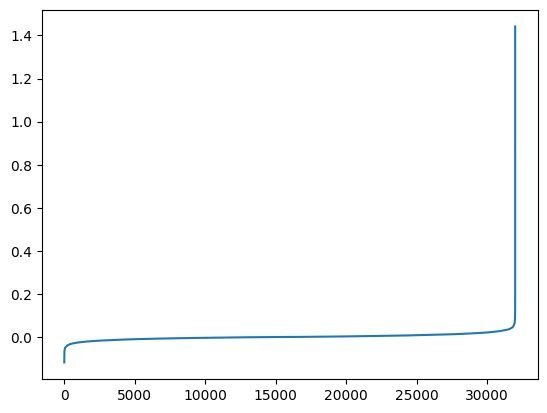

In [225]:
plt.plot(sorted(list(h_score)))